# Youtube Sentiment Analysis



*   Test on 250 comments from english videos negative unbiased



In [1]:
import torch
import pandas as pd
import nltk
import string
import regex as re
import spacy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def remove_emoji(comment):
    """Function to remove emojis.
        comment : data input ; str
        Taken from :
        https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

    """

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', comment)

In [3]:
def P_data_reading(path, i=250):
    """Simple function to read in the data we want to use.
       path : the path pointing to our data ; csv file
    """
    comments_data = pd.read_csv(path)
    return comments_data.iloc[0:i,:]['Comment']

In [4]:
def P_data_cleaning(data, language):
    """Function to clean our data.
       data : data input ; pd.Series
       language : what language the comments are in (input in lowercase) : str
    """
    # REMOVING PUNCTUATION
    data = data.apply(lambda x: "".join([word for word in x.lower() if word not in string.punctuation]))

    # REMOVING EMOJIS
    data = data.apply(lambda x: remove_emoji(x))

    # LOWERCASE
    data = data.str.lower()

    # REMOVING STOPWORDS
    data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words(language))]))



    return data

In [5]:
def P_data_lemmatizing(comment, language):
    """ Usefull for the sentiment analysis and the word cloud.
       comment : the current comment to analyze ; string
       language : the language for tokenization ; string
    """
    if language.lower() == 'english':
      lemmatizer = spacy.load("en_core_web_sm")


    lemmatized_comment = ' '.join([token.lemma_ for token in lemmatizer(comment)])


    # After lemmatizing, some words are again higher cased
    lemmatized_comment = lemmatized_comment.lower()


    return lemmatized_comment

In [6]:
def P_data_word_count(data):
    """Usefull for the word cloud.
       data : data input : pd.Series
    """
    # explode() : convert each single element into a row
    # We also sort them to find the most common ones
    word_counts = data.str.split().explode().value_counts().sort_values(ascending = False)





    # We return the count aswell as the (lemmatized) words themselves
    return word_counts, list(word_counts.index)

In [7]:
def V_word_cloud(data):
    """Visualization tool. A word cloud so we can see what words appears most.
       data : contains the counts of each word ; pd.Series
    """

    # Convert the series to a concatenated string
    comment_words = ' '.join([str(w) for w in data.index])

    # Generate the word cloud
    wordcloud = WordCloud(width=512, height=512, background_color='white', max_words=20).generate(comment_words)

    # Display the word cloud
    plt.figure(figsize=(10, 8), facecolor='white', edgecolor='blue')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


In [8]:
# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Make sure the model is in evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [10]:
# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Disable gradient calculations
    with torch.no_grad():
        # Forward pass
        outputs = model(**inputs)

    # Get the predicted labels
    predicted_label = torch.argmax(outputs.logits, dim=-1).item()

    # Convert the predicted label to sentiment
    sentiment = "Positive" if predicted_label == 1 else "Negative"

    return sentiment

In [11]:
# Define the path
path = '/Test_250.csv'

In [12]:
# Build the dataset
data = P_data_reading(path) # data is a Series

In [13]:
# Clean the dataset
data_cleaned = P_data_cleaning(data, language = 'english')
csv_file = 'data_cleaned.csv'
data_cleaned.to_csv(csv_file, index = False)

In [14]:
# Lemmatize the dataset
data_cleaned_lemmatized = data_cleaned.apply(lambda x : P_data_lemmatizing(x, language = 'english'))
csv_file = 'data_cleaned_lemmatized.csv'
data_cleaned_lemmatized.to_csv(csv_file, index = False)

In [15]:
# Count the words
data_words_count, words = P_data_word_count(data_cleaned_lemmatized)

In [16]:
# Convert the Series into a Dataframe
data_cleaned_and_labels = data_cleaned.to_frame()

In [17]:
# Add the prediction to the dataset
data_cleaned_and_labels['Predicted sentiment'] = data_cleaned_and_labels['Comment'].apply(predict_sentiment)
csv_file = 'output.csv'
data_cleaned_and_labels.to_csv(csv_file, index = False)

<Axes: xlabel='Predicted sentiment'>

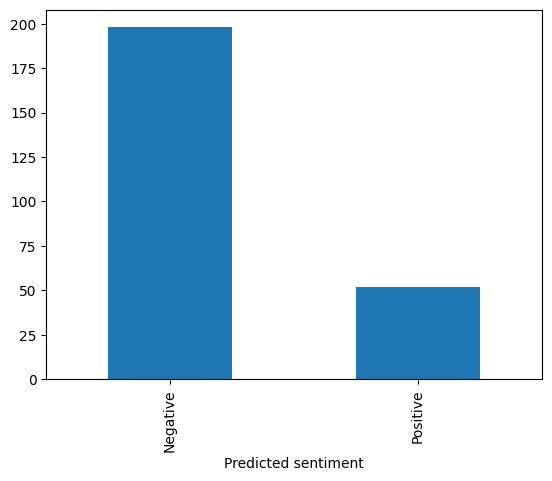

In [18]:
# Plot the number of labels
data_cleaned_and_labels['Predicted sentiment'].value_counts().plot(kind='bar')

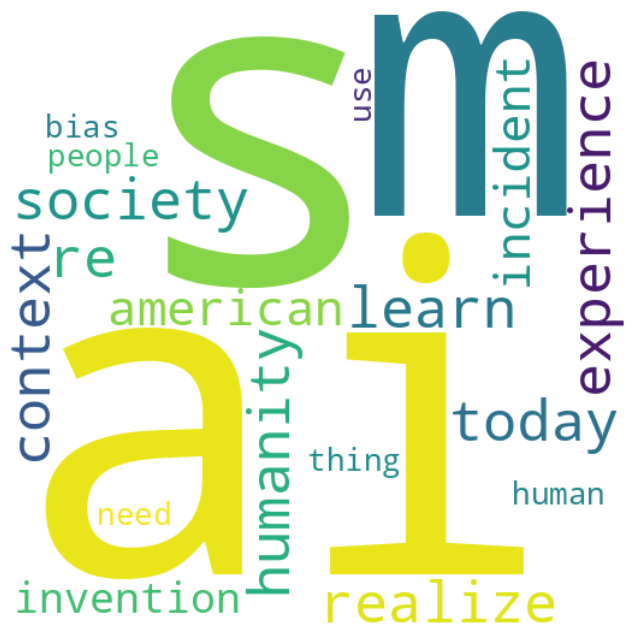

In [19]:
# Create the word cloud with the filtered data
data_words_count, words = P_data_word_count(data_cleaned_lemmatized)
V_word_cloud(data_words_count)

In [20]:
# See the most frequent words
data_words_count.head(25)

Comment
ai         247
not         83
like        64
people      61
do          59
need        53
use         40
human       37
bias        35
thing       33
make        32
one         28
we          27
would       26
problem     26
go          26
impact      25
work        25
model       24
say         23
well        22
could       22
real        21
think       21
create      20
Name: count, dtype: int64